Q1 - Keyword Spotting & Deployment (Section 12.8)

Extracting Audio Features (This may take a minute)...
Training Samples: 2500, Test Samples: 500
Input Shape: 26
Training Audio Model...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1575 - loss: 15.2366
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3793 - loss: 1.8415
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5752 - loss: 1.1876
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6383 - loss: 1.0273
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6506 - loss: 1.0122
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7094 - loss: 0.8212
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7094 - loss: 0.8795
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7642 - loss: 0.6372
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7669 - loss: 0.6976
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7534 - loss: 0.8954
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8086 - loss: 0.5558
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - l

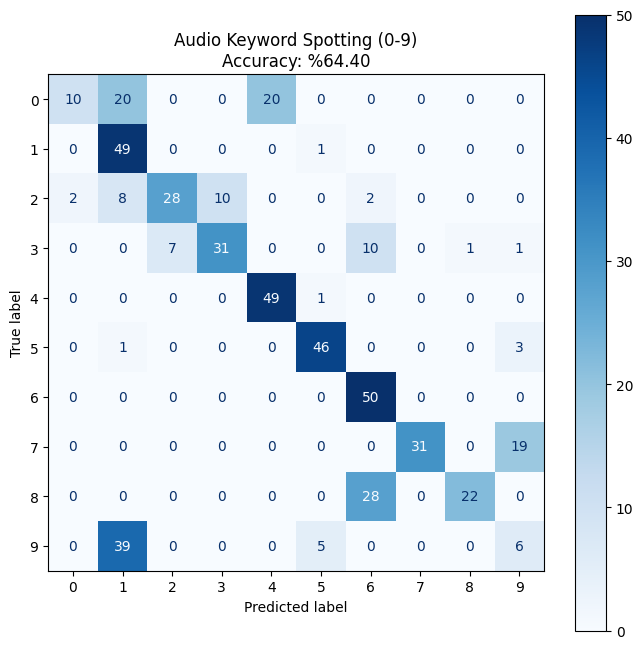

Generating C files for STM32...
Saved artifact at '/tmp/tmp6hewzq5r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 26), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138231384851856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231384859728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231384850896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231384863376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231384858384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231384852432: TensorSpec(shape=(), dtype=tf.resource, name=None)
Files created: q1_audio_model_data.h, audio_model.tflite


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import os
import numpy as np
import tensorflow as tf
import librosa
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from google.colab import files

print("Downloading Free Spoken Digit Dataset (FSDD)...")
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git > /dev/null 2>&1

RECORDINGS_DIR = "free-spoken-digit-dataset/recordings"
filenames = [f for f in os.listdir(RECORDINGS_DIR) if f.endswith('.wav')]

print("Extracting Audio Features (This may take a minute)...")

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=8000)

    if len(audio) < 8000:
        padding = 8000 - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')

    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    deltas = librosa.feature.delta(mfccs)

    mfccs_mean = np.mean(mfccs.T, axis=0)
    deltas_mean = np.mean(deltas.T, axis=0)

    return np.concatenate((mfccs_mean, deltas_mean))

train_features = []
train_labels = []
test_features = []
test_labels = []


TEST_SPEAKER = "yweweler"

for fname in filenames:
    path = os.path.join(RECORDINGS_DIR, fname)
    digit = int(fname.split('_')[0])
    speaker = fname.split('_')[1]

    features = extract_features(path)

    if speaker == TEST_SPEAKER:
        test_features.append(features)
        test_labels.append(digit)
    else:
        train_features.append(features)
        train_labels.append(digit)

X_train = np.array(train_features)
y_train = np.array(train_labels)
X_test = np.array(test_features)
y_test = np.array(test_labels)

print(f"Training Samples: {len(X_train)}, Test Samples: {len(X_test)}")
print(f"Input Shape: {X_train.shape[1]}")


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=(26,), activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

print("Training Audio Model...")

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(X_train, y_train, epochs=100, verbose=1, callbacks=[callback])


print("Evaluating Audio Model...")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: %{acc*100:.2f}")

predictions = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title(f"Audio Keyword Spotting (0-9)\nAccuracy: %{acc*100:.2f}")
plt.savefig("q1_audio_confusion.png")
plt.show()


print("Generating C files for STM32...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('audio_model.tflite', 'wb') as f:
    f.write(tflite_model)

def hex_to_c_array(hex_data, var_name="audio_kws_model"):
    c_str = f'const unsigned char {var_name}[] = {{\n'
    for i, val in enumerate(hex_data):
        c_str += f'0x{val:02x}, '
        if (i + 1) % 12 == 0: c_str += '\n'
    c_str += '\n};\n'
    c_str += f'unsigned int {var_name}_len = {len(hex_data)};'
    return c_str

with open('audio_model.tflite', 'rb') as f:
    c_code = hex_to_c_array(f.read())

with open('q1_audio_model_data.h', 'w') as f:
    f.write(c_code)

print("Files created: q1_audio_model_data.h, audio_model.tflite")
files.download('q1_audio_confusion.png')
files.download('q1_audio_model_data.h')

Q2 Code: Handwritten Digit Recognition & Deployment (Section 12.9)

Loading MNIST dataset...
Extracting Hu Moments (7 features per image)...
Training MLP Model...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4427 - loss: 1.5911
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5452 - loss: 1.2879
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5615 - loss: 1.2391
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5696 - loss: 1.2128
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5771 - loss: 1.1835
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5802 - loss: 1.1677
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5875 - loss: 1.1606
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5935 - loss: 1.1398
Epoch 9/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5987 - loss: 1.1328
Epoch 10/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5966 - loss: 1.1265
Epoch 11/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5974 - loss: 1.1298
Epoch 12/50
1875/1875 ━━━━━━━━━━━━━━━━━━━

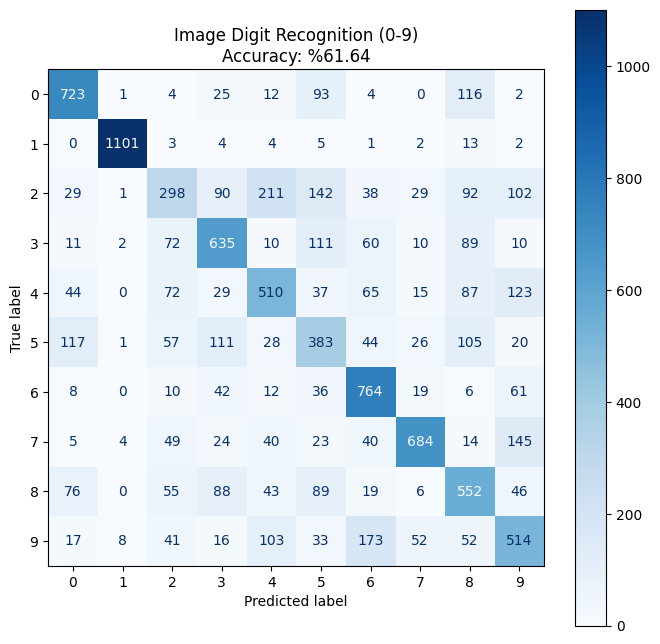

Converting model to TensorFlow Lite and C Array...
Saved artifact at '/tmp/tmp_su2rsd9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138231148447312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231148459024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231148459984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231148451152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231141504144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138231141504720: TensorSpec(shape=(), dtype=tf.resource, name=None)
Files generated: q2_image_model_data.h, image_model.tflite, q2_image_confusion.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import files
import os

print("Loading MNIST dataset...")
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def extract_hu_moments(images):
    hu_moments = np.empty((len(images), 7))
    for idx, img in enumerate(images):
        moments = cv2.moments(img, binaryImage=False)
        hu = cv2.HuMoments(moments).reshape(7)
        hu_moments[idx] = hu
    return hu_moments

print("Extracting Hu Moments (7 features per image)...")
train_huMoments = extract_hu_moments(train_images)
test_huMoments = extract_hu_moments(test_images)


features_mean = np.mean(train_huMoments, axis=0)
features_std = np.std(train_huMoments, axis=0)

train_huMoments = (train_huMoments - features_mean) / features_std
test_huMoments = (test_huMoments - features_mean) / features_std


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=(7,), activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Training MLP Model...")
model.fit(train_huMoments, train_labels, epochs=50, verbose=1)

print("Evaluating model and generating confusion matrix...")
predictions = model.predict(test_huMoments)
predicted_classes = np.argmax(predictions, axis=1)


acc = np.mean(predicted_classes == test_labels)
print(f"Test Accuracy: %{acc*100:.2f}")

cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title(f"Image Digit Recognition (0-9)\nAccuracy: %{acc*100:.2f}")

plt.savefig("q2_image_confusion.png", dpi=300)
plt.show()

print("Converting model to TensorFlow Lite and C Array...")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_filename = 'image_model.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

def hex_to_c_array(hex_data, var_name="image_mnist_model"):
    c_str = f'const unsigned char {var_name}[] = {{\n'
    for i, val in enumerate(hex_data):
        c_str += f'0x{val:02x}, '
        if (i + 1) % 12 == 0:
            c_str += '\n'
    c_str += '\n};\n'
    c_str += f'unsigned int {var_name}_len = {len(hex_data)};'
    return c_str

with open(tflite_filename, 'rb') as f:
    hex_data = f.read()
    c_code = hex_to_c_array(hex_data)

header_filename = 'q2_image_model_data.h'
with open(header_filename, 'w') as f:
    f.write(c_code)

print(f"Files generated: {header_filename}, {tflite_filename}, q2_image_confusion.png")

print("Downloading files...")
files.download('q2_image_confusion.png')
files.download('q2_image_model_data.h')